### Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA

C:\Users\User\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### Load data & data understanding

In [2]:
df = pd.read_csv('AirPassengers.csv')

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


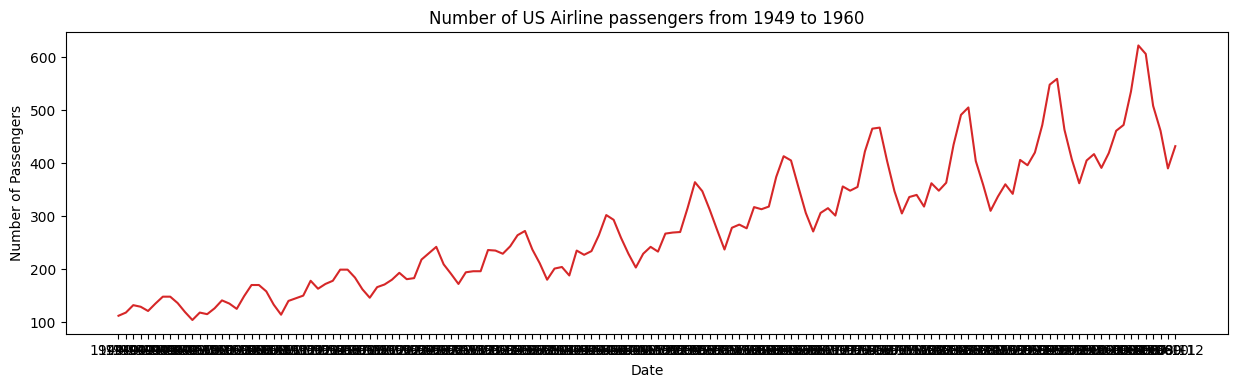

In [3]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(df, x=df['Month'], y=df['#Passengers'], title='Number of US Airline passengers from 1949 to 1960')

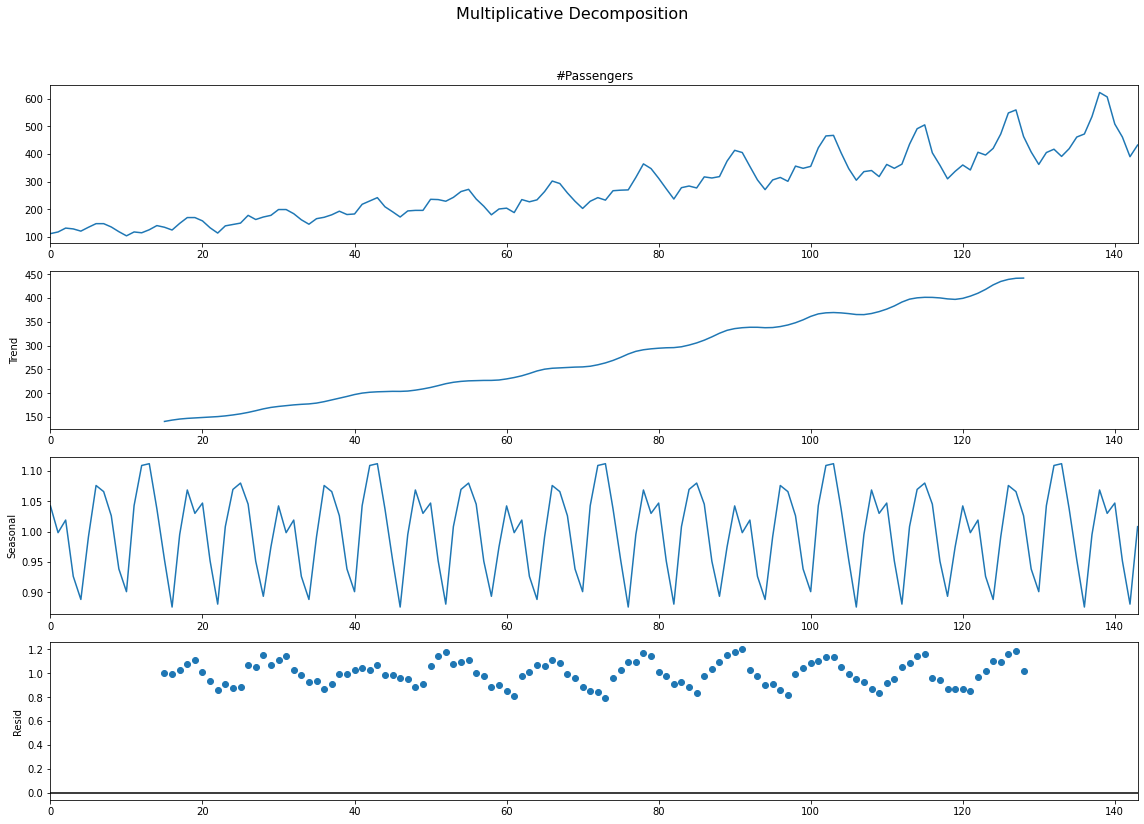

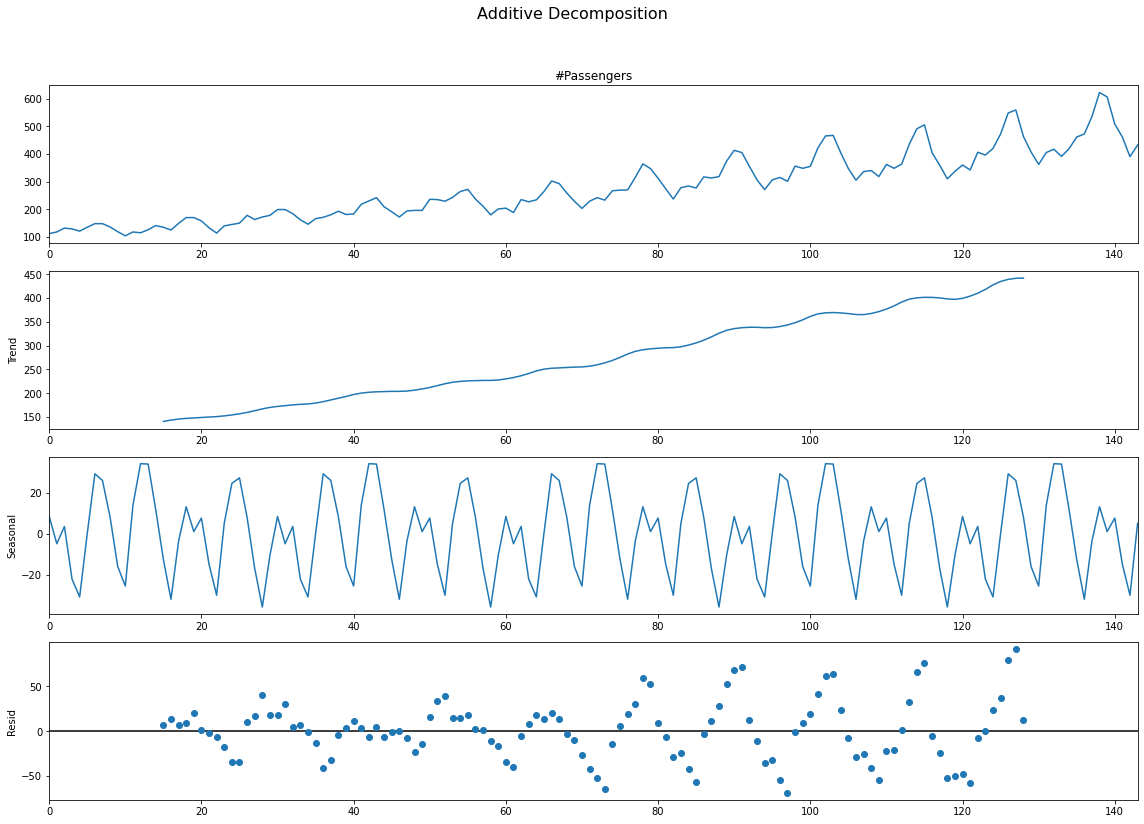

In [4]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['#Passengers'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['#Passengers'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [5]:
df['Month'] = pd.to_datetime(df.Month)
df = df.set_index(df.Month)
df.drop('Month', axis = 1, inplace = True)
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 #Passengers    int64
dtype: object


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot:title={'center':'Seasonality of the Time Series'}, xlabel='Month', ylabel='#Passengers'>

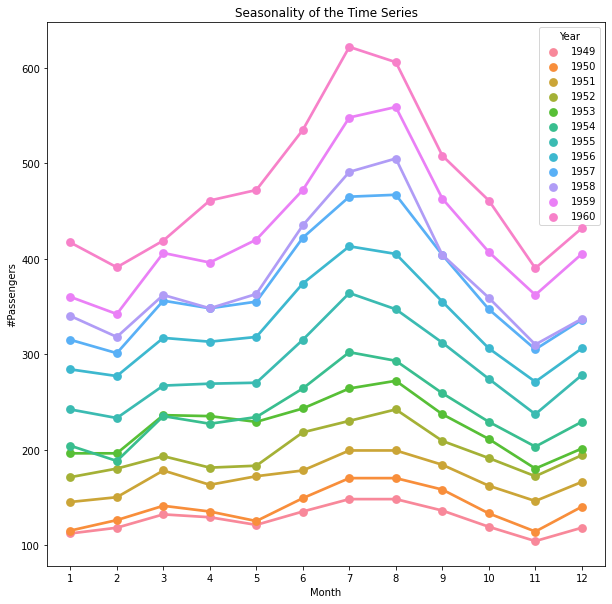

In [6]:
df_temp = df.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='#Passengers',hue='Year',data=df_temp)

### Check for Stationarity
Dickey-Fuller test

In [7]:
def test(df):
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(df)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)
test(df)

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value > 0.05 - not stationary

### Convert  to Stationary Data

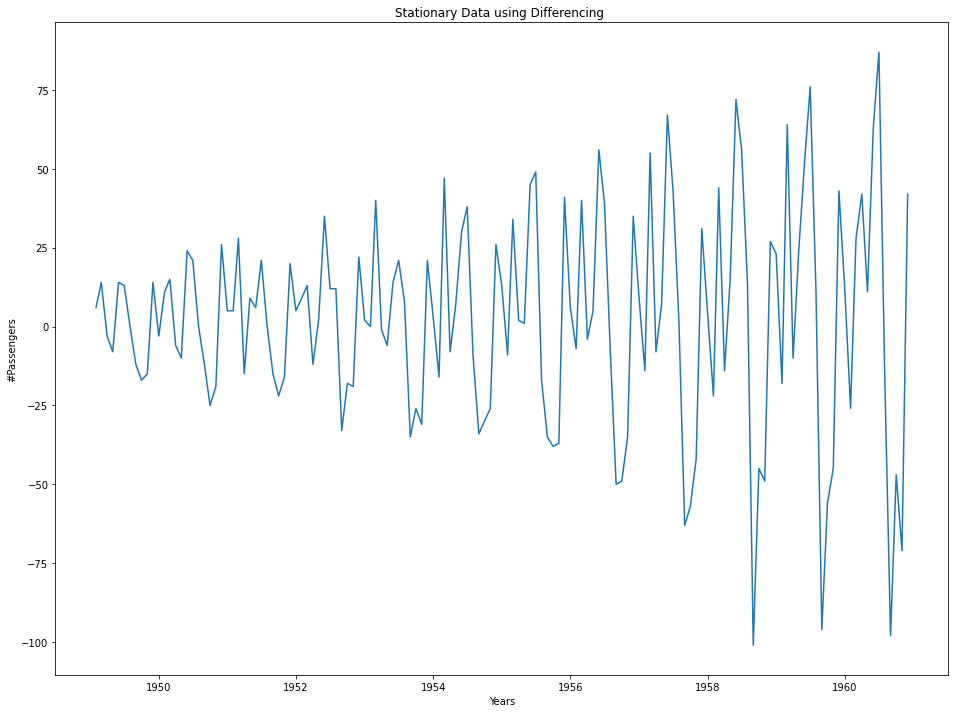

In [8]:
df_diff = df.diff(periods = 1)
plt.xlabel('Years')
plt.ylabel('#Passengers')    
plt.title('Stationary Data using Differencing ')
plt.plot(df_diff)

In [9]:
df_diff.dropna(inplace = True)
test(df_diff)

Results of Dickey-Fuller Test
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value > 0.05 -  not perfectly stationary

In [10]:
df_log = np.log(df)
df = np.exp(df_log)
df_log_diff = df_log.diff(periods = 1) 

df_log_diff.dropna(inplace = True)
test(df_log_diff)

Results of Dickey-Fuller Test
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


p-value > 0.05 - not perfectly stationary

### Forecasting 

ARIMA 

#### ACF and PACF Plots

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


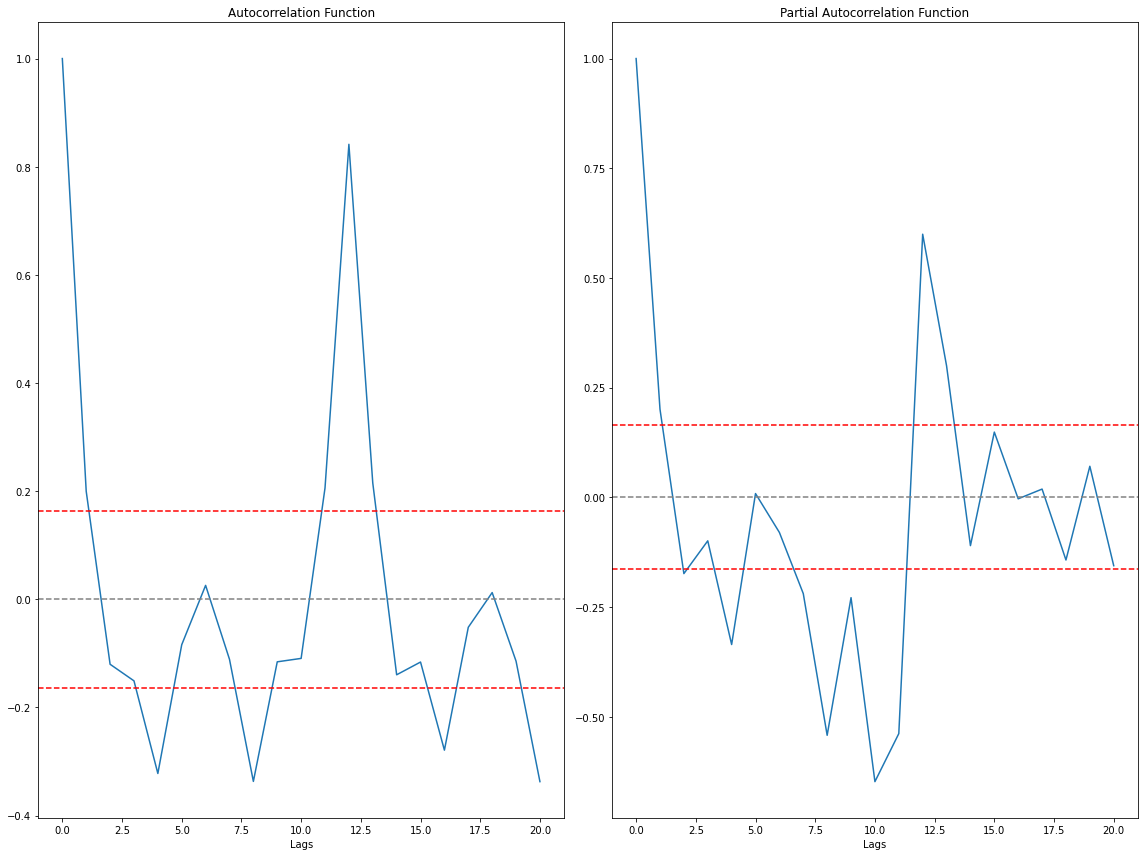

In [11]:
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

p,q = 2

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA 

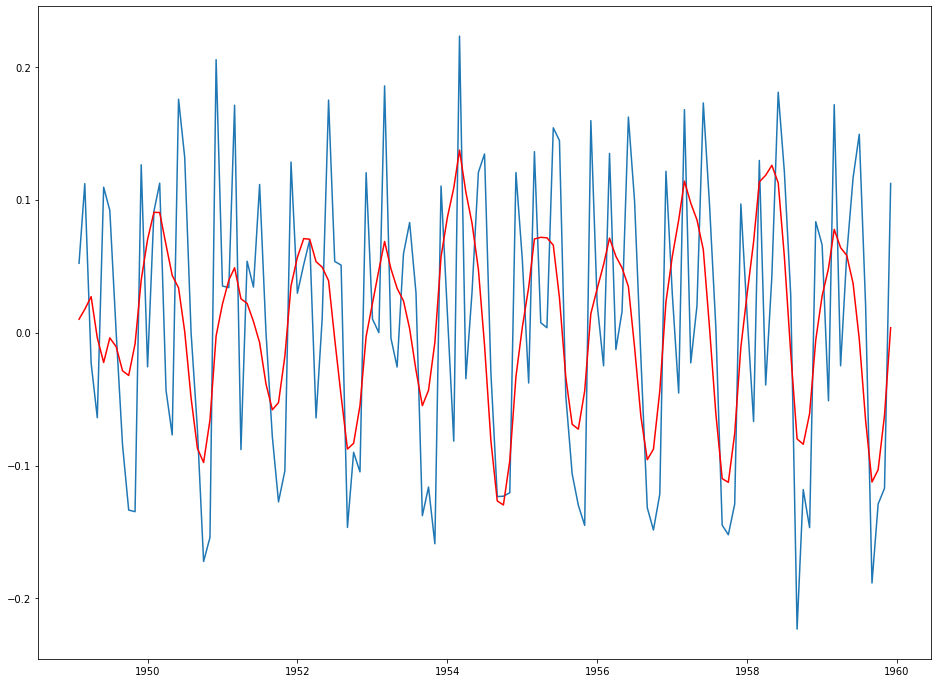

In [12]:
model = ARIMA(df_log[:-12], order=(2, 1, 2), freq = 'MS')   #(p,d,q)
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_diff[:-12])
plt.plot(results_ARIMA.fittedvalues, color='red')

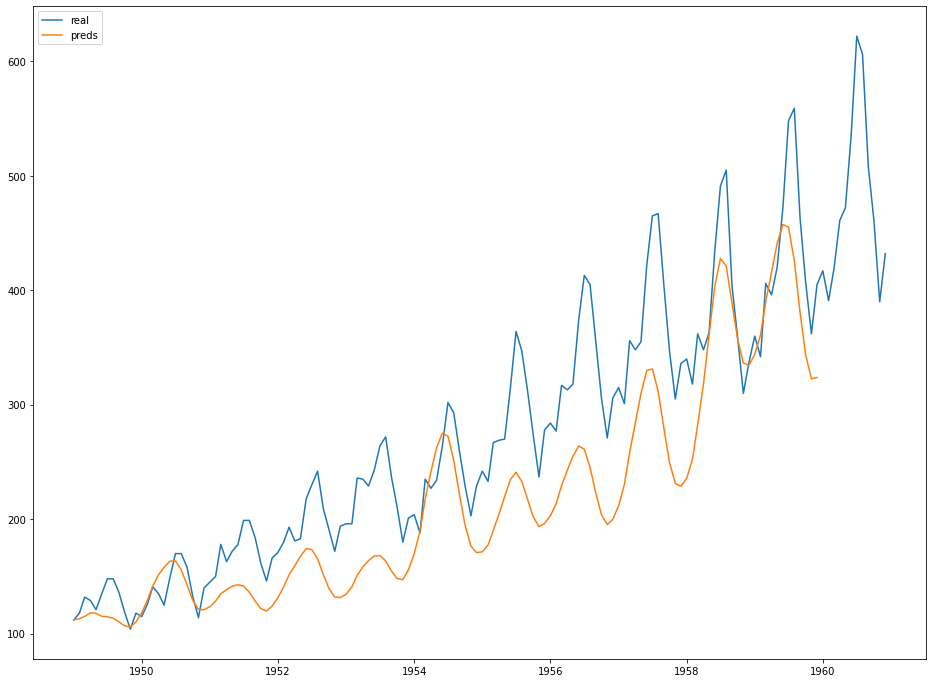

In [52]:
predictions_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_log = pd.Series(df_log['#Passengers'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_diff_cumsum,fill_value=0)
predictions = np.exp(predictions_log[:-12])
plt.plot(df, label = 'real')
plt.plot(predictions, label = 'preds')
plt.legend()

In [36]:
df

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [42]:
forecast_values_log_scale = results_ARIMA.forecast(steps = 12)
forecast_values_original_scale = np.exp(forecast_values_log_scale[0])
forecast_date_range= pd.date_range("1960-01-01", "1960-12-01", freq="MS")

df_forecast =pd.DataFrame(forecast_values_original_scale, columns=['Forecast'])
df_forecast['Month'] = forecast_date_range

df_forecast[['Month', 'Forecast']]
df_forecast['Month'] = pd.to_datetime(df_forecast.Month)
df_forecast = df_forecast.set_index(df_forecast.Month)
df_forecast.drop('Month', axis = 1, inplace = True)

In [43]:
df_forecast

,Forecast
Month,
1960-01-01,421.968476
1960-02-01,452.618577
1960-03-01,490.415487
1960-04-01,526.279746
1960-05-01,550.974340
1960-06-01,558.842013
1960-07-01,550.359539
1960-08-01,531.458749
1960-09-01,510.333557


In [40]:
df[-12:]

,#Passengers
Month,
1960-01-01,417.0
1960-02-01,391.0
1960-03-01,419.0
1960-04-01,461.0
1960-05-01,472.0
1960-06-01,535.0
1960-07-01,622.0
1960-08-01,606.0
1960-09-01,508.0


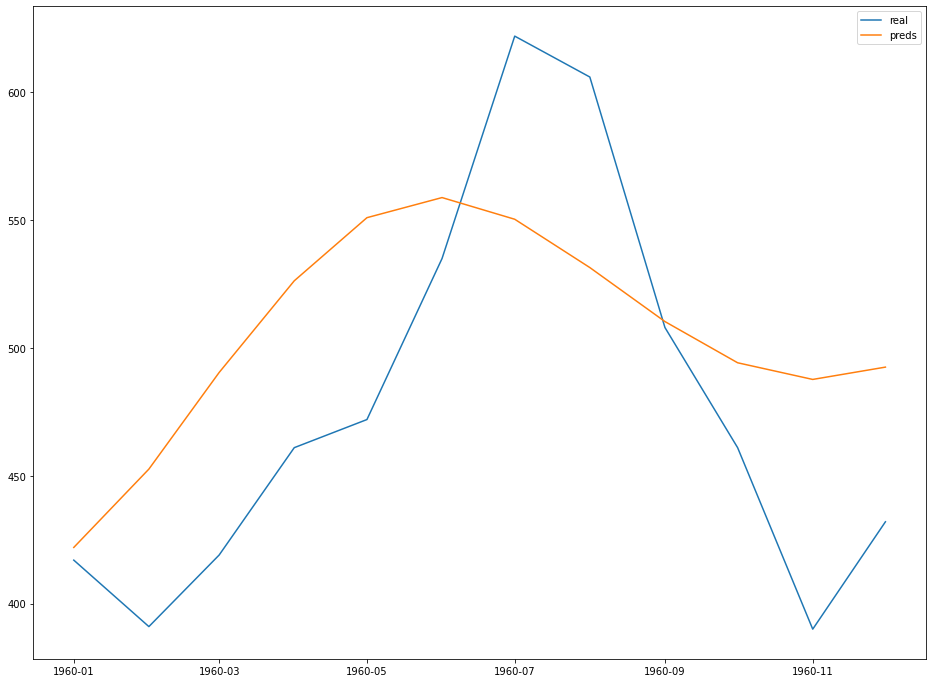

In [49]:
 
real = df[-12:]

plt.plot(real, label='real')
plt.plot(df_forecast, label='preds')
plt.legend()

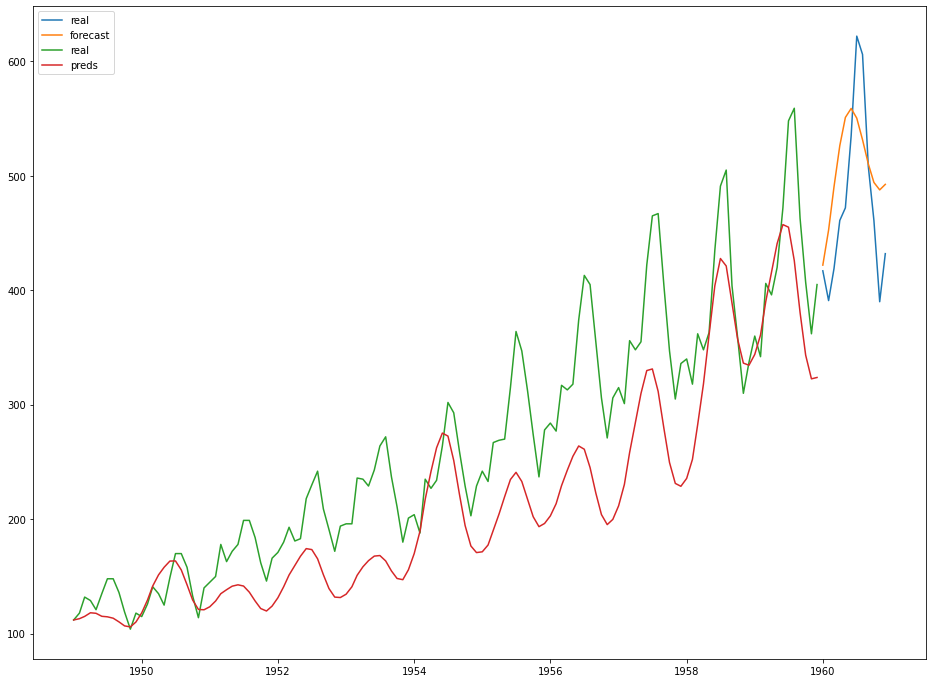

In [56]:
plt.plot(real, label = 'real')
plt.plot(df_forecast, label = 'forecast')
plt.plot(df[:-12], label = 'real')
plt.plot(predictions, label = 'preds')
plt.legend()

### Podsumowanie
1. Wykonane kroki:
 - Analiza i zrozumienie zbioru danych, dekompozycja (trend, sezonowość), wydobycie charakterystyk serii.
 - Eksploracja transformacji aby uzyskać serię stacjonarną, badanie testem Dickey-Fuller'a, wybór metody, dla której możliwa jest odwrotna transformacja, zastosowano różnicowanie i przekształcenie logarytmiczne. 
 - Wybór odpowiedniego modelu ARIMA (dane po transformacji nie są do końca stacjonarne)
 - Dobór parametrów modelu q i p przy użyciu ACF i PACF - odczytanie wartości z wykresu (pierwsze przecięcie z górną granicą)
 - Uczenie modelu i predykcja + transformacja do pierwotnej skali
2. Wnioski
- Dokładne wartości liczbowe odbiegają nieco od rzeczywistych, jednak udało się odwzorować ogólną charakterystykę serii.
- Da się wykonać transformacje, tak aby test Dickey-Fuller'a wypadał lepiej, ale trzeba pamiętać o odwracalności